# Solução - Parte 2:  Validação Cruzada Para Seleção de Modelos

## Objetivos:

O objetivo desse desafio é compreender como funciona a validação cruzada e os benefícios em se utilizar essa técnica para selecionar modelos mais genéricos.


## Conceitos:

A validação cruzada é uma técnica de avaliação de um modelo em treinamento que permite estimar a capacidade de **generalização** do mesmo. A idéia por trás da técnica é validar qual seria o desempenho do modelo, treinado com uma parte dados, sobre o resto dos dados, nunca vistos antes pelo modelo. 

Essa técnica possibilita que se teste essa hipótese sem ser necessário ter uma base de testes extra, o que é muito útil quando se têm poucos dados. O diagrama abaixo resume a idéia central da técnica:


![Diagrama explicativo: Cross-Validation usando K-Fold com ${K = 10}$](images/k-fold-diagram.png)

A técnica mais comum, denominada `K-Fold`, consiste em particionar o dataset em $K$ grupos, treinar com $K-1$ grupos de dados e validar o modelo treinado sobre o grupo restante. Deve-se repetir esse passo $K$ vezes, para que todos os grupos sejam usados, e então calcular as métricas de avaliação como a média das métricas calculadas em cada iteração. Uma outra maneira de se fazer isso é armazenar a predição sobre todos os dados **quando em validação** e calcular as métricas de desempenho sobre essas predições.

O limite dessa técnica é o `Leave-One-Out`, caso é o extremo em que se particiona o dataset em $N$ grupos. Esse limite, quando possível, traz a informação mais acurada sobre a capacidade de generalização do modelo. Essa técnica tem como desvantagem a quantidade enorme de treinamentos realizados: um para cada elemento da base de treino.

___

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import os
import pandas as pd

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics.regression import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Dataset:

## Sobre o Case

### Case baseado no dataset do Kaggle: "California Housing Prices"

Esse desafio é baseado em um dataset aberto do Kaggle ([https://www.kaggle.com](https://www.kaggle.com)) de 2018, de onde é possível estimar o preço de um imóvel pertencente a uma dada região na Califórnia. 

O dataset original foi extraído do repositório StatLib, que não está mais disponível. Os dados que o compôem foram retirados do Censo realizado na Califórnia em 1990 e modificado para servir como base de treinamento.


Link para o dataset no Kaggle: [https://www.kaggle.com/harrywang/housing/data](https://www.kaggle.com/harrywang/housing/data)


### Descrição dos Dados Originais:

#### Tamanho do Dataset:

* `20.640` data points

#### Variável dependente:

* `median_house_value`:  (float) variável dependente com o valor da mediana do preço de imóvel na região

#### Features: 

* `longitude`/`latitude`: (floats) posição global da região
* `housing_median_age`: (float) mediana da idade (em anos) das casas da região
* `total_rooms`: (float) total de aposentos da região
* `total_bedrooms`: (float) total de quartos da região
* `population`: (float) população total da região
* `households`: (float) quantidade total de imóveis da região
* `median_income`: (float) mediana do salário (por hora) de uma pessoa na região
* `ocean_proximity`: (string) categorias relativas à distância do oceano


### Modificação dos dados para o Desafio:

Para tornar o desafio mais fácil de avaliar, a massa de dados original foi dividida em duas massas, uma para treino e outra para teste, ambas contendo pouco mais de `10.000` elementos. 

Por motivos didáticos, alguns elementos da massa de treino foram removidos e, sobre os elementos restantes, foi aplicada uma Feature Engineering. Não é necesário se preocupar com o que é uma Feature Engineering agora, será o tema da Aula 20. 

## Carregando os dados

### Train Dataset 

In [4]:
dataset = pd.read_csv("data/feature_engineered_california_housing_train.csv", sep="\t", index_col=0)
x_train = dataset.drop(["median_house_value"], axis=1)
y_train = dataset[["median_house_value"]]

In [5]:
print(f"shape: {x_train.shape}")
x_train.head()

shape: (10038, 88)


,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,housing_median_age,total_rooms,total_bedrooms,population,households,...,population^3,population^2 households,population^2 median_income,population households^2,population households median_income,population median_income^2,households^3,households^2 median_income,households median_income^2,median_income^3
region_id,,,,,,,,,,,,,,,,,,,,,
1,8.867709,7.008505,7.783641,7.037028,2.116424,21.0,7099.0,1106.0,2401.0,1138.0,...,1.384129e+10,6.560344e+09,4.785592e+07,3.109401e+09,2.268223e+07,165460.693946,1.473760e+09,1.075068e+07,78423.269350,572.076387
2,7.290975,5.247024,6.206576,5.176150,1.982022,52.0,1467.0,190.0,496.0,177.0,...,1.220239e+08,4.354483e+07,1.785437e+06,1.553918e+07,6.371417e+05,26124.247961,5.545233e+06,2.273671e+05,9322.564293,382.246204
4,7.394493,5.634790,6.336826,5.556828,1.347086,52.0,1627.0,280.0,565.0,259.0,...,1.803621e+08,8.267928e+07,1.227803e+06,3.790076e+07,5.628337e+05,8358.188759,1.737398e+07,2.580069e+05,3831.452900,56.897815
9,8.174421,6.561031,7.346655,6.570883,1.305952,52.0,3549.0,707.0,1551.0,714.0,...,3.731087e+09,1.717599e+09,8.879554e+06,7.906936e+08,4.087687e+06,21132.308989,3.639943e+08,1.881759e+06,9728.219612,50.292443
10,7.697121,6.073045,6.813445,5.996452,1.164119,52.0,2202.0,434.0,910.0,402.0,...,7.535710e+08,3.328962e+08,2.652487e+06,1.470596e+08,1.171758e+06,9336.463145,6.496481e+07,5.176338e+05,4124.459543,32.863324


In [6]:
print(f"shape: {y_train.shape}")
y_train.head()

shape: (10038, 1)


,median_house_value
region_id,
1,358500.0
2,352100.0
4,342200.0
9,261100.0
10,281500.0


### Test Dataset 

In [7]:
dataset = pd.read_csv("data/feature_engineered_california_housing_test.csv", sep="\t", index_col=0)
x_test = dataset.drop(["median_house_value"], axis=1)
y_test = dataset[["median_house_value"]]

In [8]:
print(f"shape: {x_test.shape}")
x_test.head()

shape: (10320, 88)


,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,housing_median_age,total_rooms,total_bedrooms,population,households,...,population^3,population^2 households,population^2 median_income,population households^2,population households median_income,population median_income^2,households^3,households^2 median_income,households median_income^2,median_income^3
region_id,,,,,,,,,,,,,,,,,,,,,
0,6.779922,4.859812,5.774552,4.836282,2.119287,41.0,880.0,129.0,322.0,126.0,...,3.338625e+07,13064184.0,8.631900e+05,5112072.0,3.377700e+05,22317.483523,2000376.0,1.321709e+05,8732.928335,577.010912
3,7.149917,5.459586,6.324359,5.389072,1.730434,52.0,1274.0,235.0,558.0,219.0,...,1.737411e+08,68188716.0,1.757058e+06,26762238.0,6.895981e+05,17769.274306,10503459.0,2.706487e+05,6973.962497,179.702136
5,6.823286,5.361292,6.023448,5.262690,1.257864,52.0,919.0,213.0,413.0,193.0,...,7.044500e+07,32919817.0,6.000447e+05,15383837.0,2.804083e+05,5111.131229,7189057.0,1.310383e+05,2388.494739,43.536195
6,7.837949,6.192362,6.997596,6.242223,1.297217,52.0,2535.0,489.0,1094.0,514.0,...,1.309339e+09,615173704.0,4.379343e+06,289030424.0,2.057570e+06,14647.580014,135796744.0,9.667196e+05,6881.952584,48.991737
7,8.040447,6.532334,7.053586,6.472346,1.137833,52.0,3104.0,687.0,1157.0,647.0,...,1.548817e+09,866105903.0,4.176585e+06,484330613.0,2.335566e+06,11262.700800,270840023.0,1.306060e+06,6298.156800,30.371328


In [9]:
print(f"shape: {y_test.shape}")
y_test.head()

shape: (10320, 1)


,median_house_value
region_id,
0,452600.0
3,341300.0
5,269700.0
6,299200.0
7,241400.0


## Normalizando Features com Z-Score

Passo importante quando se treina modelos lineares, por eliminar importâncias artificialmente grandes para features contendo valores muito grandes.

In [10]:
columns = x_train.columns

In [11]:
zscore = StandardScaler().fit(x_train.loc[:, columns])

In [12]:
x_train.loc[:, columns] = zscore.transform(x_train.loc[:, columns])
x_test.loc[:, columns] = zscore.transform(x_test.loc[:, columns])

# Problemas

## A) Seleção de Hiperparâmetros

O uso mais comum da técnica é a seleção dos `hiperparâmetros` que definem o modelo; 
diferente dos parâmetros do modelo, que são ajustados a cada iteração do treinamento, os hiperparâmetros são condições fixadas sob as quais o treinamento ocorre. Um exemplo de hiperparâmetro é o $alpha$, definido para treinamentos das regressões `Ridge` e `Lasso`.

Nessa seção, será feita a busca pelos melhores hiperparâmetros de treinamento usando a $ElasticNet$, que combina a regularização `L1` e `L2` em um modelo único. 

### Escolha dos Hiperparâmetros

Os hiperparâmetros a serem variados são:
* `alpha`: mesmo parâmetro visto em Regularização, define a intensidade da regularização no modelo.
* `l1_ratio `: define o tipo de regularização, como mostrado abaixo:
    * $l1\_ratio = 1$: o treinamento ocorre com `L1` apenas
    * $l1\_ratio = 0$: o treinamento ocorre com `L2` apenas
    * $0 \leq l1\_ratio \leq 1$: o treinamento ocorre com uma combinação de `L1` com `L2` na proporção dada.

#### Variação dos hiperparâmetros

In [13]:
# hiperparâmetros
param_grid = {
    "alpha": np.logspace(1, 4, 11),          # Por quê `logspace`?
    "l1_ratio": np.linspace(0.01, 1.0, 11),
    "max_iter": [100],
    "positive": [True]
}

##### Treinamento dos modelos

Usar o [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para treinar um conjunto de modelos com a combinação de todos os hiperparâmetros.

Parâmetros a serem utilizados:

* `estimator`: [`ElasticNet()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
* `param_grid `: `param_grid`
* `scoring`: 'r2'
* `cv`: usar [`KFold(n_splits=10, shuffle=True, random_state=42)`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
* `random_state`: 42

In [14]:
grid = GridSearchCV(
    ElasticNet(), 
    param_grid=param_grid, 
    scoring='r2',
    cv=KFold(n_splits=10, shuffle=True, random_state=42)
)

In [15]:
grid.fit(x_train, y_train)

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([    10.     ,     19.95262,     39.81072,     79.43282,
          158.48932,    316.22777,    630.95734,   1258.92541,
         2511.88643,   5011.87234,  10000.     ]), 'l1_ratio': array([ 0.01 ,  0.109,  0.208,  0.307,  0.406,  0.505,  0.604,  0.703,
        0.802,  0.901,  1.   ]), 'max_iter': [100], 'positive': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [16]:
model = grid.best_estimator_
model

In [17]:
y_pred = model.predict(x_train)
y_true = y_train
r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred)

(0.54228195516848809, 5992239045.7130499)

In [18]:
y_pred = model.predict(x_test)
y_true = y_test
r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred)

(0.53222615428271269, 6200199755.0131283)

####  Avaliação dos modelos treinados

Mostrar uma tabela contendo todos os treinamentos e suas avaliações e escolher um range de exploração onde o modelo consegue ter uma performance melhor.

Dica: usar a função [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) do `seaborn` para visualizar os melhores parâmetros.

In [19]:
results = pd.DataFrame(grid.cv_results_)[['param_alpha', 'param_l1_ratio', 'mean_test_score']]
results = results.set_index(['param_alpha', 'param_l1_ratio']).unstack()
results.columns = results.columns.droplevel(0)
results

param_l1_ratio,0.01,0.109,0.208,0.307,0.406,0.505,0.604,0.703,0.802,0.901,1.0
param_alpha,,,,,,,,,,,
10.000000,0.358288,0.370567,0.383754,0.397797,0.412712,0.428803,0.446293,0.465284,0.486236,0.509555,0.541288
19.952623,0.269495,0.283501,0.299118,0.316601,0.336299,0.358536,0.383980,0.412900,0.446438,0.486317,0.541290
39.810717,0.181624,0.194209,0.208714,0.225647,0.245655,0.269744,0.299364,0.336527,0.384174,0.446557,0.541295
79.432823,0.110800,0.120139,0.131216,0.144575,0.161021,0.181794,0.208894,0.245838,0.299542,0.384299,0.541304
158.489319,0.062419,0.068400,0.075641,0.084593,0.095953,0.110852,0.131273,0.161083,0.208956,0.299585,0.541319
316.227766,0.033117,0.036576,0.040821,0.046153,0.053058,0.062357,0.075568,0.095866,0.131158,0.208785,0.541308
630.957344,0.016708,0.018579,0.020894,0.023833,0.027688,0.032966,0.040640,0.052834,0.075269,0.130693,0.541235
1258.925412,0.007962,0.008928,0.010130,0.011665,0.013694,0.016501,0.020642,0.027363,0.040187,0.074514,0.541052
2511.886432,0.003432,0.003913,0.004513,0.005282,0.006302,0.007723,0.009835,0.013308,0.020085,0.039186,0.540040


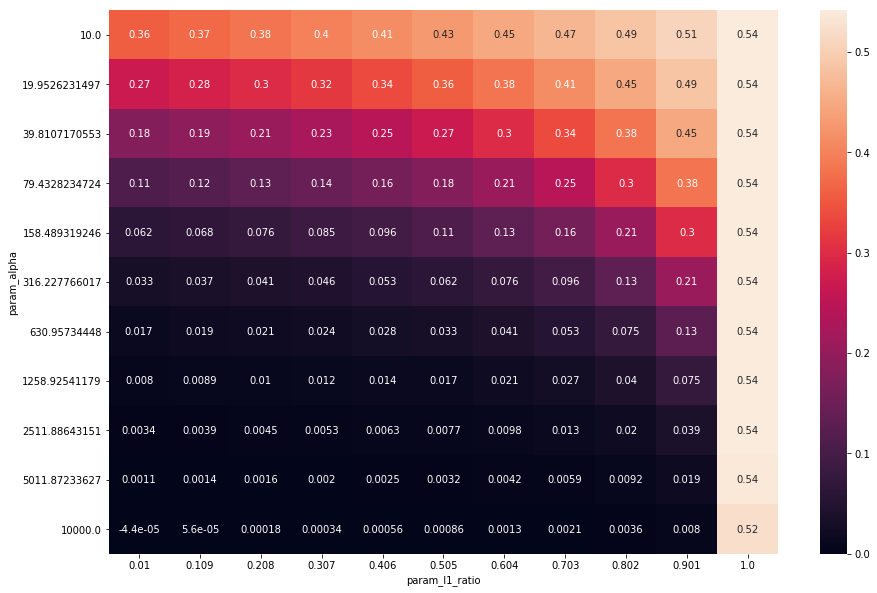

In [20]:
plt.figure(figsize=(15, 10))
sns.heatmap(results, annot=True)

## B) Estudo da influência do parâmetro $K$ sobre a generalização

Quanto mais `folds` forem usados na validação cruzada, mais realista será a estimativa do poder de generalização do modelo treinado. Como já foi citado, o uso de `LeaveOneOut` é o mais próximo de trazer essa estimativa, com o contraponto de ser o mais pesado computacionalmente.

Nessa seção, será feita uma comparação entre o desempenho dos modelos nas massas de validação (calculado com dados de treino durante a validação cruzada) e de teste. 

###### Importante:

Os hipeparâmetros a serem variados nos treinamentos devem ser obtidos na última etapa do item **A**.

####  Hiperparâmetros

Preencher `params_grid` com as faixas de hiperparâmetros de melhor performance.

In [21]:
""" Complete os espaços com ? """
param_grid = {
    "alpha": np.logspace(1, 2, 3),
    "l1_ratio": np.linspace(0.7, 1, 3),
    "max_iter": [1000],
    "positive": [True]
}

####  Treinar os modelos para os valores de $K$

Treinar os modelos para cada valor de $K$ em `k_list`. Armazenar, para cada $K$, os valores de $R^2$ médio calculados sobre a massa de **treino** e de **validação** (testes dentro do *Cross Validation*) e o $R^2$ calculado sobre a massa de **testes**.

In [22]:
k_list = [3, 5, 10, 20, 35, 60, 100]

In [23]:
""" Escreva a solução aqui """

measures = pd.DataFrame(
    columns=["train R^2", "test R^2", "validation R^2"],
    index=k_list,
    data=None
)

for k in k_list:
    # training grid search with cross-validation
    grid = GridSearchCV(
        ElasticNet(), 
        param_grid=param_grid, 
        scoring=['r2'],
        cv=KFold(n_splits=k, shuffle=True, random_state=42),
        refit=False
    )
    grid.fit(x_train, y_train)
    
    # retrieving best model validation results
    cv_results = pd.DataFrame(grid.cv_results_)
    best_index = cv_results.mean_test_r2.argmax()    
    r2_tr = cv_results.loc[best_index, 'mean_train_r2']
    r2_vd = cv_results.loc[best_index, 'mean_test_r2']
    
    # training model w/ best params
    best_params = cv_results.loc[best_index, "params"]
    model = ElasticNet(**best_params).fit(x_train, y_train)
    
    # retrieving best model's test results
    y_pred = model.predict(x_test)
    y_true = y_test
    mse_te = mean_squared_error(y_true, y_pred)
    r2_te = r2_score(y_true, y_pred)
    
    # filling measures table
    measures.loc[k, "train R^2"] = r2_tr
    measures.loc[k, "test R^2"] = r2_te
    measures.loc[k, "validation R^2"] = r2_vd

measures

,train R^2,test R^2,validation R^2
3,0.542414,0.53208,0.541344
5,0.54241,0.53208,0.541471
10,0.542335,0.53208,0.541315
20,0.542311,0.53208,0.540574
35,0.542301,0.53208,0.540436
60,0.542295,0.53208,0.538299
100,0.542292,0.53208,0.53783


####  Avaliação da generalização

Mostrar em um plot a comparação entre os valores de $R^2$ calculados sobre as massa de treino, teste e validação para cada variação de $K$. 

* Eixo X: valores de $K$
* Eixo Y: valores de $R^2$

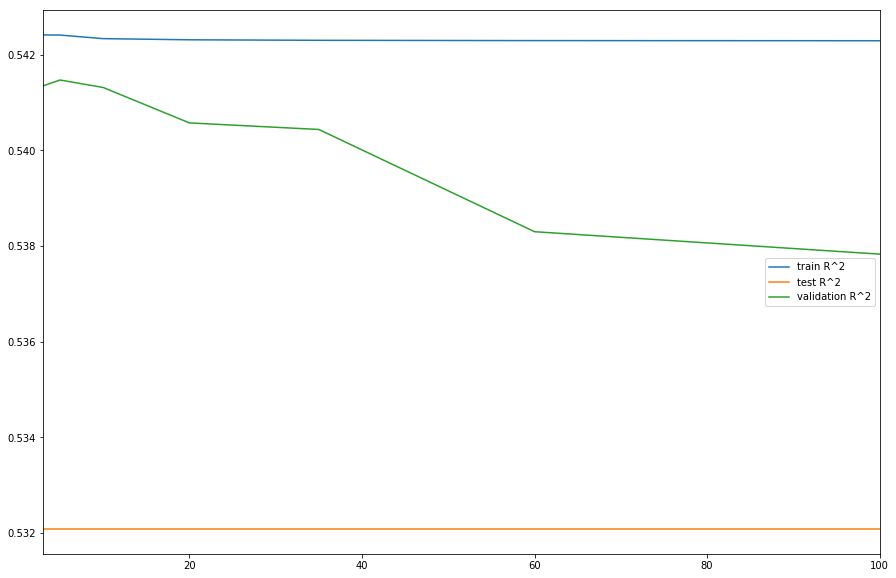

In [24]:
""" Escreva a solução aqui """
_ = measures[["train R^2", "test R^2", "validation R^2"]].plot(figsize=(15,10))

###### Nota sobre o exercício:

Pode-se notar que, quanto maior o valor de $K$, mais conservador (i.e. pessimista) será a estimativa do $R^2$ sobre a massa de validação. O plot mostra claramente que a curva de $R^2$ de validação se aproxima do valor calculado sobre a massa de teste; levado ao limite do *LeaveOneOut*, onde $K==N$, os valores de $R^2$ calculados sobre ambas as massas devem se encontrar.